#  Next Purchase Date Prediction

**Purpose**: The purpose of this part is to use machine learning to predict a customer's propensity to make a purchase in the next seven days based on recency, frequency, and monetary value features. 

**Business Benefit**: Knowing the approximate date that customer is expected to make a purchase is critical for strategic marketing. If a customer doesn’t make a purchase within the expected timeframe, the marketing team can target him with an incentive to increase the likelihood that he will make a purchase. 

**Data Set Information**: This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

**Data Source**: [Online Retail Data Set](http://archive.ics.uci.edu/ml/datasets/online+retail)

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import datetime as dt 
df = pd.read_excel('data/Online Retail.xlsx')

# Data Preprocessing

Before building our machine learning models, we must clean our data: 
- 1) Data type conversion
- 2) Remove erroneous data
- 3) Remove missing values 
- 4) Remove duplicate rows 

In [2]:
df.shape

(541909, 8)

Our data set has 541,909 rows and 8 columns.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [4]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
# Convert CustomerID to object type 
df['CustomerID'] = df['CustomerID'].astype('object')

In [6]:
df.describe()

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


There are negative values associated with both *Quantity* and *UnitPrice*. Let's investigate why these values are negative.

In [7]:
# Investigate negative "Quantity" values
df[df["Quantity"] < 0].head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
239,C536391,21484,CHICK GREY HOT WATER BOTTLE,-12,2010-12-01 10:24:00,3.45,17548.0,United Kingdom
240,C536391,22557,PLASTERS IN TIN VINTAGE PAISLEY,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
241,C536391,22553,PLASTERS IN TIN SKULLS,-24,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
939,C536506,22960,JAM MAKING SET WITH JARS,-6,2010-12-01 12:38:00,4.25,17897.0,United Kingdom


The invoice numbers associated with negative quantity values start with a "C". This represents orders that were cancelled. 

In [8]:
# Investigate negative "UnitPrice" values
df[df["UnitPrice"] < 0].head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom


Negative *UnitPrice* values are associated wtih adjusted bad debt. We will remove these values along with negative quantity values.

In [9]:
# Remove negative quantity values and negative UnitPrice values
df = df[(df['Quantity'] > 0)]
df = df[(df['UnitPrice'] > 0)]

In [10]:
#Check unique value for each column in df
def unique_counts(df):
    for i in df.columns:
        count = df[i].nunique()
        print(i, ": ", count)
unique_counts(df)

InvoiceNo :  19960
StockCode :  3922
Description :  4026
Quantity :  375
InvoiceDate :  18499
UnitPrice :  1291
CustomerID :  4338
Country :  38


Let's check if there are any missing values.

In [11]:
# Check for missing values 
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     132220
Country             0
dtype: int64

*CustomerID* has many missing values. We will remove these rows with missing values from our dataframe.

In [12]:
# Remove null values for CustomerID
df = df[pd.notnull(df['CustomerID'])]

Let's also check for rows with duplicate values.  

In [13]:
# Check for duplicates
df.duplicated().sum()

5192

We will remove these duplicate rows from our dataframe. 

In [14]:
# Remove duplicates 
df = df.drop_duplicates()

# Feature Engineering

Feature engineering involves using domain expertise to develop features that are compatible with machine learning algorithms. I will use feature engineering to create RFM (recency, frequency, and monetary) features and a seven day target window for prediction. 

- **Recency**: The number of days since a customer's last purchase.
- **Frequency**: The total number of purchases a customer made. 
- **Monetary Value**: Total amount a customer spent. 

In [15]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Let's create a column for total price. 

In [16]:
# Create total price column
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

Next, we will create a dataframe to hold data in our target window (last 7 days). We'll also create another dataframe for data before the target window.

In [17]:
# Convert RegistrationTime to datetime object  
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
print(df['InvoiceDate'].min())
print(df['InvoiceDate'].max())

2010-12-01 08:26:00
2011-12-09 12:50:00


In [18]:
# Create data frame without target window data 
# Target windows is the last 7 days
df1 = df[df['InvoiceDate'] < '2011-12-3']
df1.shape

(379725, 9)

In [19]:
# Create new dataframe to hold data in the prediction/target window 
df2 = df[df['InvoiceDate'] >= '2011-12-3']
df2.shape

(12967, 9)

In [20]:
# Create target column for df2 
df2 = df2.assign(Purchase=1)
df2.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,Purchase
522165,580384,22193,RED DINER WALL CLOCK,2,2011-12-04 10:10:00,8.50,17243.0,United Kingdom,17.00,1
522166,580384,23355,HOT WATER BOTTLE KEEP CALM,2,2011-12-04 10:10:00,4.95,17243.0,United Kingdom,9.90,1
522167,580384,22114,HOT WATER BOTTLE TEA AND SYMPATHY,7,2011-12-04 10:10:00,4.25,17243.0,United Kingdom,29.75,1
522168,580384,22835,HOT WATER BOTTLE I AM SO POORLY,5,2011-12-04 10:10:00,4.95,17243.0,United Kingdom,24.75,1
522169,580384,22112,CHOCOLATE HOT WATER BOTTLE,4,2011-12-04 10:10:00,4.95,17243.0,United Kingdom,19.80,1


In [21]:
# For df2 (target window dataframe), remove all columns except for CustomerID and Purchase
df2 = df2.loc[:, ['CustomerID','Purchase']]

In [22]:
df2 = df2.set_index('CustomerID')

D:\NEXUS\SOFTWARE\Anaconda\lib\site-packages\pandas\core\indexes\base.py:6999: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


In [23]:
df2.head()

,Purchase
CustomerID,
17243.0,1
17243.0,1
17243.0,1
17243.0,1
17243.0,1


Now we can proceed with creating RFM features. To calculate *recency*, we need to find out how many days have passed since each customer's last purchase. *Frequency* can be computed by counting the number of unique invoices from each customer. *Monetary value* equals the sum of each customer's purchases.

In [24]:
# Create Recency, Frequency, and Monetary Features
most_recent = dt.datetime(2011,12,3)
features1 = df1.groupby('CustomerID').agg({'InvoiceDate': lambda x: (most_recent - x.max()).days, 
                                          'InvoiceNo': lambda x: x.nunique(),
                                          'TotalPrice': lambda x: x.sum()})

features1['InvoiceDate'] = features1['InvoiceDate'].astype(int)

features1.rename(columns={'InvoiceDate': 'Recency', 
                         'InvoiceNo': 'Frequency',
                         'TotalPrice': 'Monetary Value'}, inplace=True)

Let's create a new feature called *days since first purchase*. This feature tells us how many days have gone by since the customer's first purchase. 

In [25]:
# Create days since first purchase column
features2 = df1.groupby('CustomerID').agg({'InvoiceDate': lambda x: (most_recent - x.min()).days})
features2['InvoiceDate'] = features2['InvoiceDate'].astype(int)
features2.rename(columns={'InvoiceDate': 'days since first purchase'}, inplace=True)

In [26]:
# Combine features into one dataframe 
features = pd.merge(features1, features2, left_index=True, right_index=True)

Let's also create an *Avg Time Between Purhases* feature since other researchers have found that the average time between purchases is a predictor of future purchases.  

In [27]:
# Create new feature: average time between each purchase 
features['Avg Time Between Purchases'] = (features['days since first purchase'] - features['Recency'])/features['Frequency']

Now we'll join the target window to the dataframe with our features.  

In [28]:
# Join the target window column to features dataframe 
features = features.join(df2).fillna(0)
features = features.drop_duplicates(keep='first')

In [29]:
features.head()

,Recency,Frequency,Monetary Value,days since first purchase,Avg Time Between Purchases,Purchase
CustomerID,,,,,,
12346.0,318,1,77183.60,318,0.000000,0.0
12347.0,32,6,4085.18,360,54.666667,1.0
12348.0,68,4,1797.24,351,70.750000,0.0
12349.0,11,1,1757.55,11,0.000000,0.0
12350.0,303,1,334.40,303,0.000000,0.0


In [30]:
features.shape

(4307, 6)

In [31]:
# Purchase distribution
print("Did not purchase during the target window:", features['Purchase'][features['Purchase'] == 0].count()) #class = 0
print("Purchased during the target window:", features['Purchase'][features['Purchase'] == 1].count()) #class = 1

Did not purchase during the target window: 3874
Purchased during the target window: 433


The data is heavily imbalanced. The majority class (customers who did not make a purchase during the target window) outnumbers the minority class (customers who purchased during the target window) by nearly 8:1. Imbalanced data will have a negative impact on model accuracy. We will address this issue later at the model development stage. 

In [32]:
features.dtypes

Recency                         int32
Frequency                       int64
Monetary Value                float64
days since first purchase       int32
Avg Time Between Purchases    float64
Purchase                      float64
dtype: object

In [33]:
# Convert recency and purchase to int64
features['Recency']= features['Recency'].astype('int64')
features['Purchase']= features['Purchase'].astype('int64')

# Data Visualization

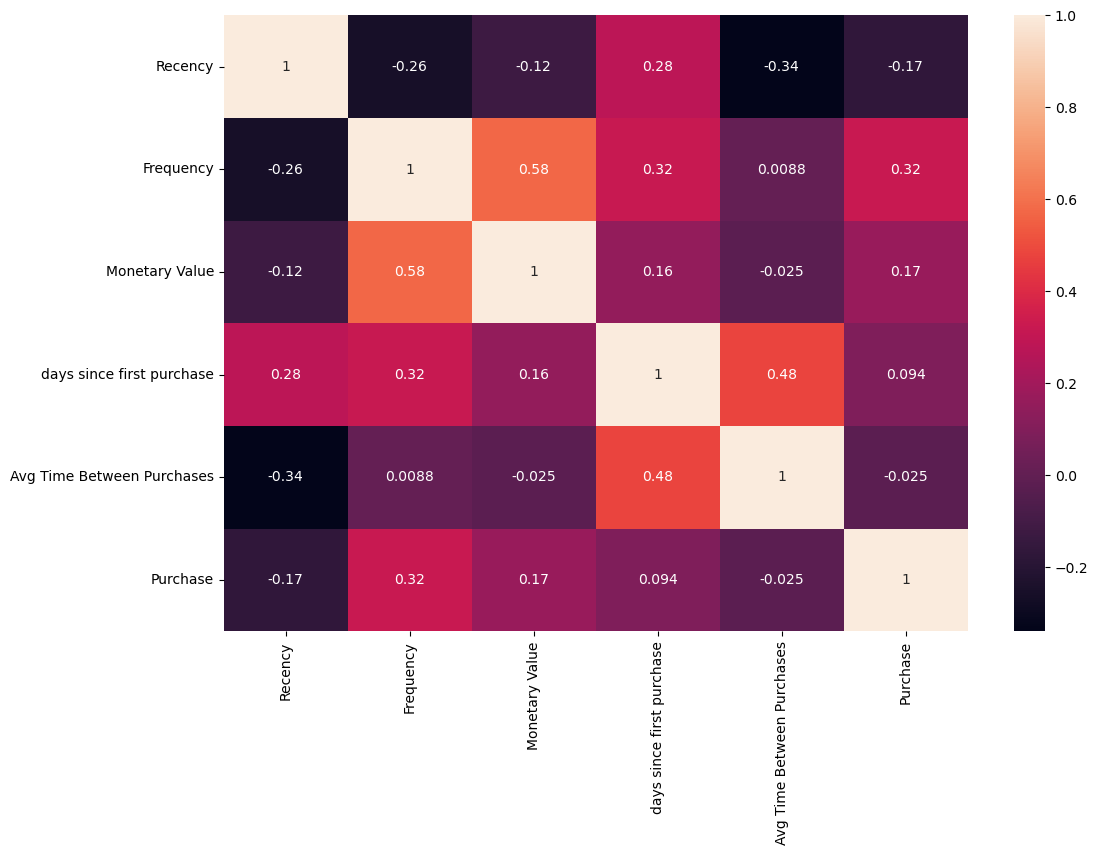

In [34]:
import seaborn as sns

plt.figure(figsize = (12, 8))
features_corr = features.corr()

sns.heatmap(features_corr, annot = True)
plt.show()

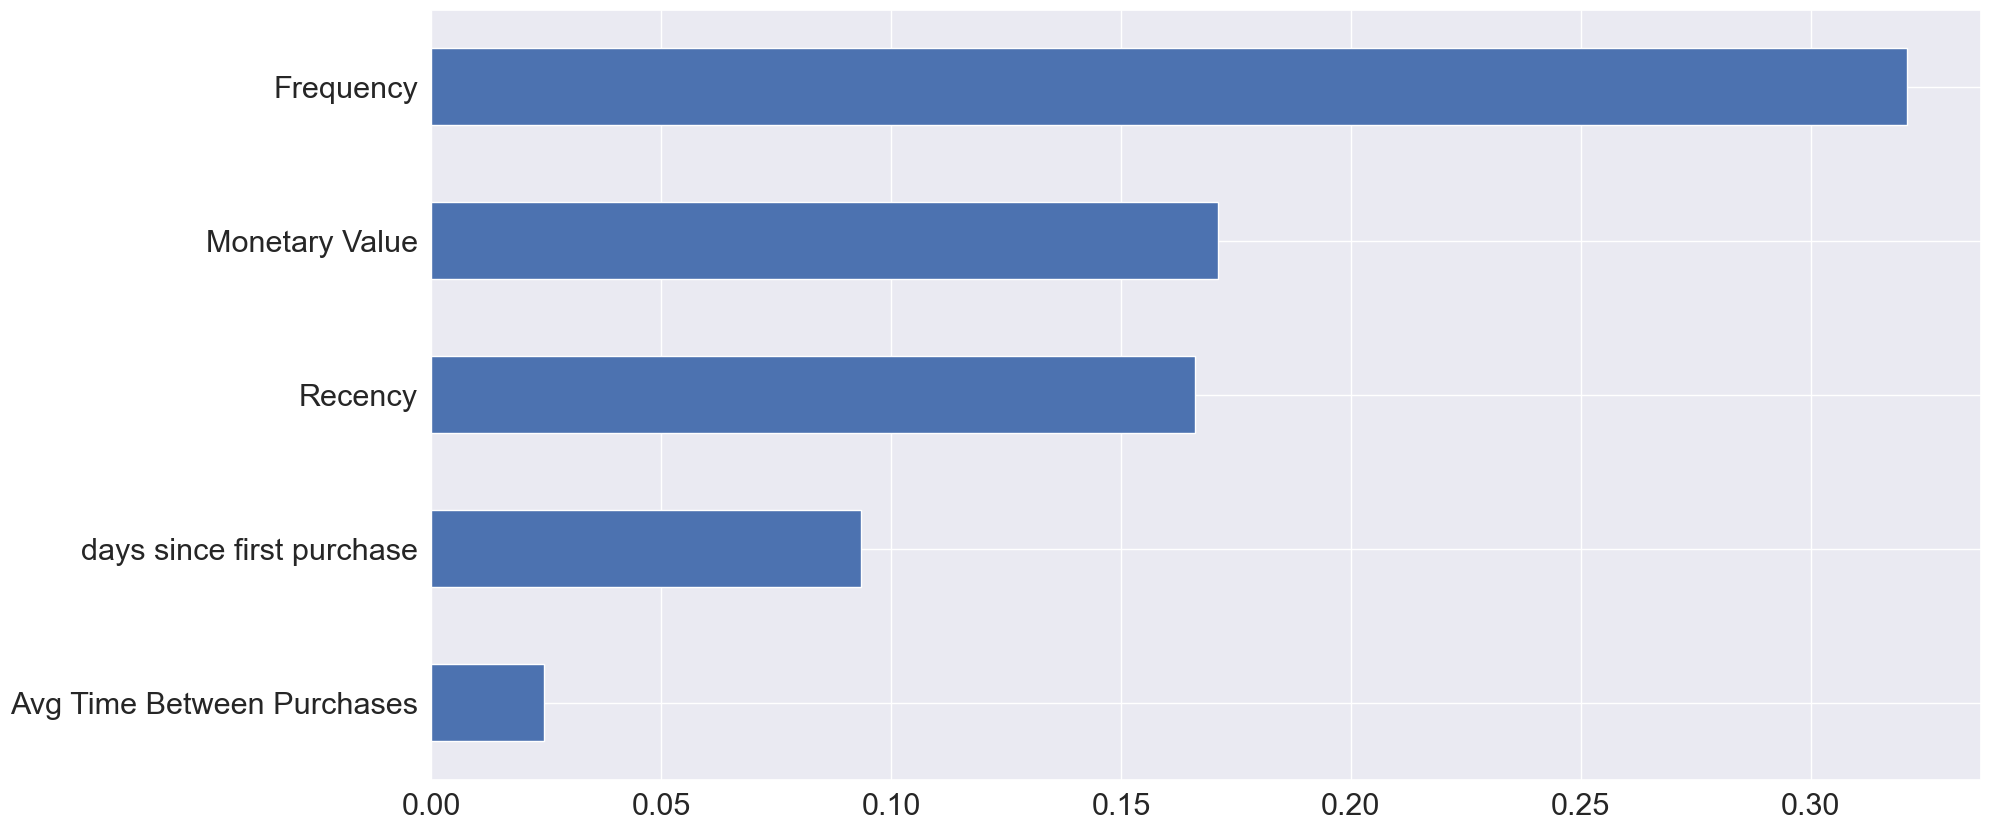

In [35]:
plt.figure(figsize = (20, 10))
sns.set(font_scale = 2)
(abs(features_corr)
 .Purchase
 .drop('Purchase')
 .sort_values()
 .plot
 .barh())
plt.savefig('OnlineRetail.png')
plt.show()

D:\NEXUS\SOFTWARE\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\NEXUS\SOFTWARE\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


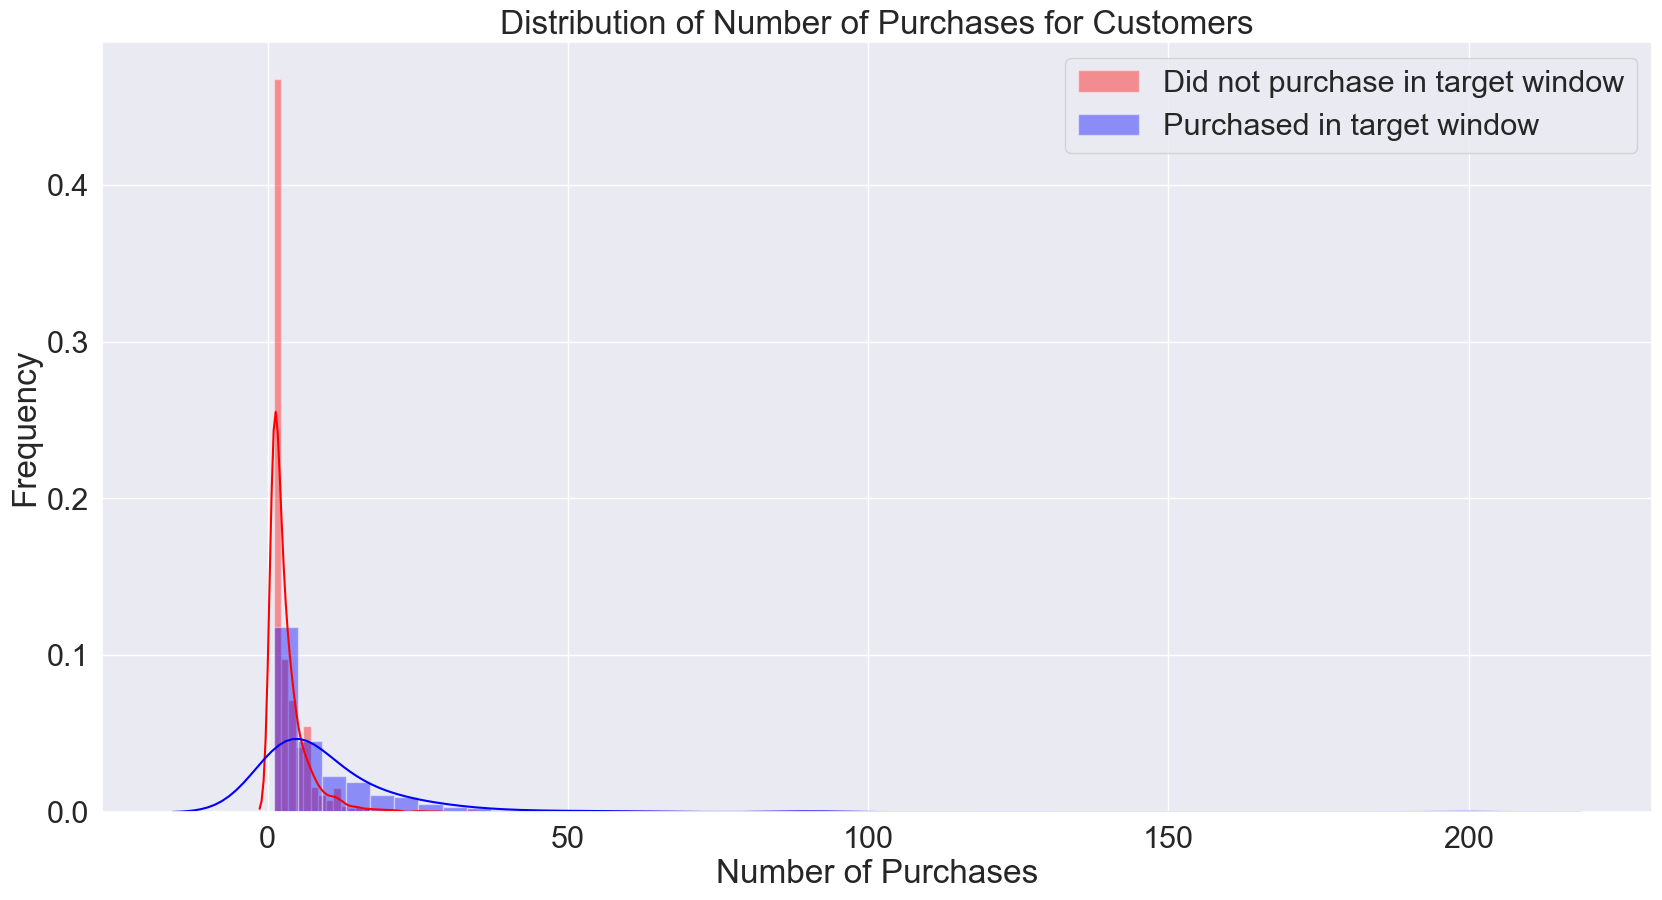

In [36]:
plt.figure(figsize = (20, 10))

sns.distplot(features[features['Purchase']==0]['Frequency'], color = 'red', label='Did not purchase in target window')
sns.distplot(features[features['Purchase']==1]['Frequency'], color = 'blue', label='Purchased in target window')
plt.ylabel('Frequency')
plt.xlabel('Number of Purchases')
plt.title('Distribution of Number of Purchases for Customers')
plt.legend()
plt.show()

Customers who made a purchase in the target window have a higher total purchase count than customers who didn’t make a purchase in the target window. A majority of people who didn't make a purchase in target window were one-time customers.

D:\NEXUS\SOFTWARE\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\NEXUS\SOFTWARE\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


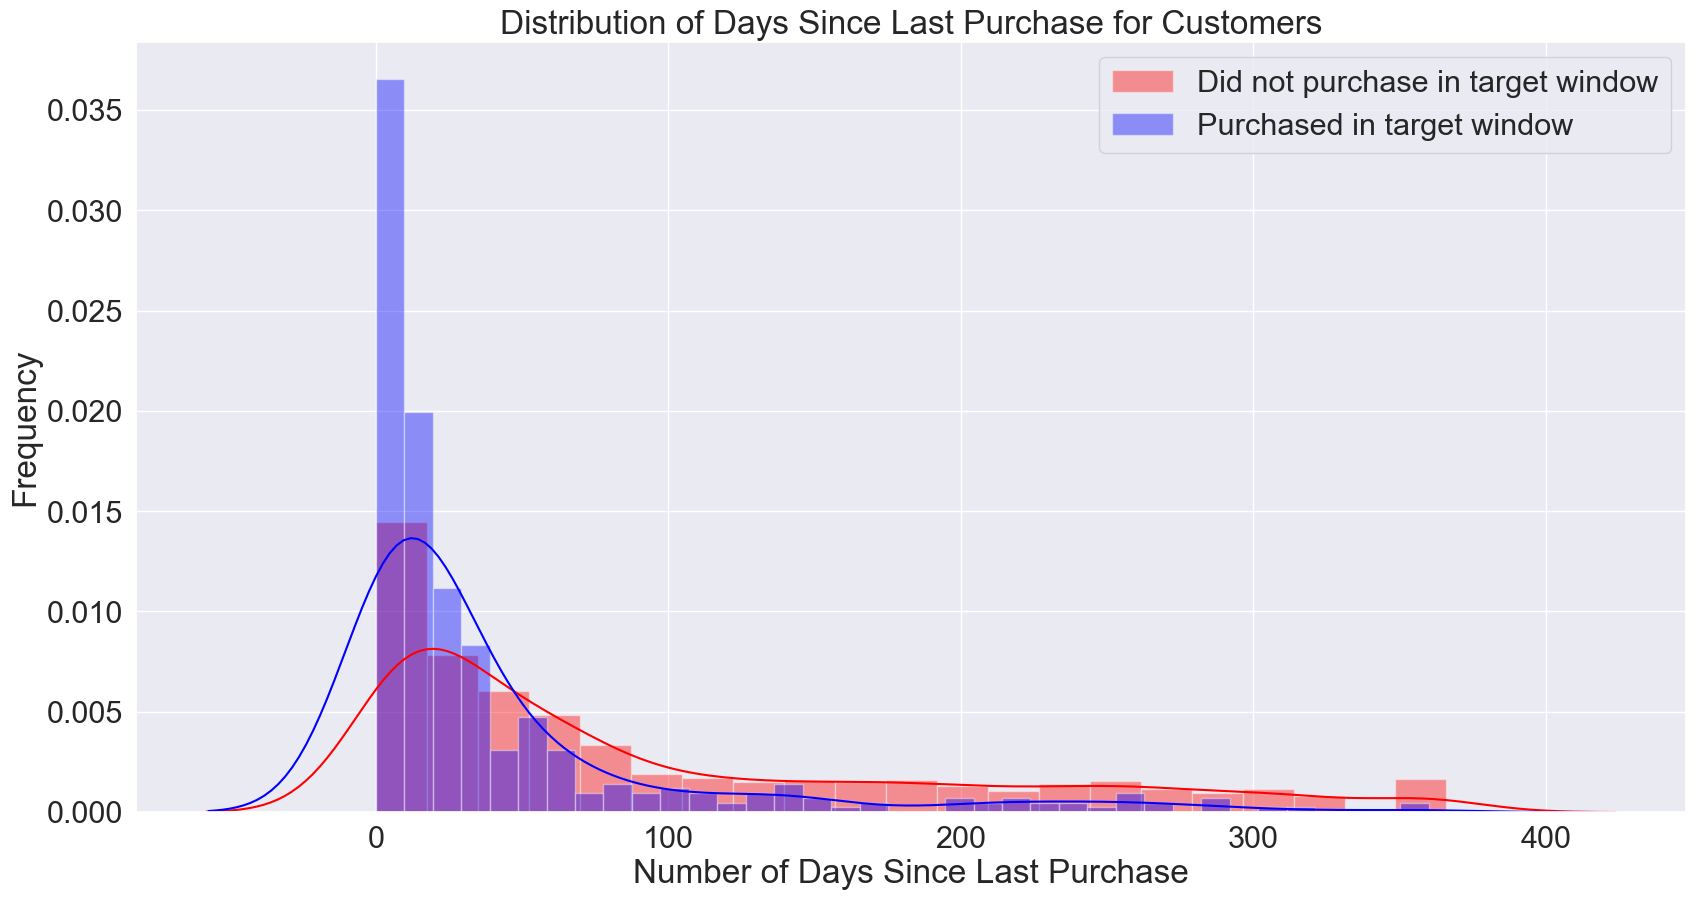

In [37]:
plt.figure(figsize = (20, 10))

sns.distplot(features[features['Purchase']==0]['Recency'], color = 'red', label='Did not purchase in target window')
sns.distplot(features[features['Purchase']==1]['Recency'], color = 'blue', label='Purchased in target window')
plt.ylabel('Frequency')
plt.xlabel('Number of Days Since Last Purchase')
plt.title('Distribution of Days Since Last Purchase for Customers')
plt.legend()
plt.show()

Most of the customers who made a purchase in the target window also made a purchase in the past 60 days. Thus, they have higher recency than those who did not purchase in the target window. 

D:\NEXUS\SOFTWARE\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\NEXUS\SOFTWARE\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


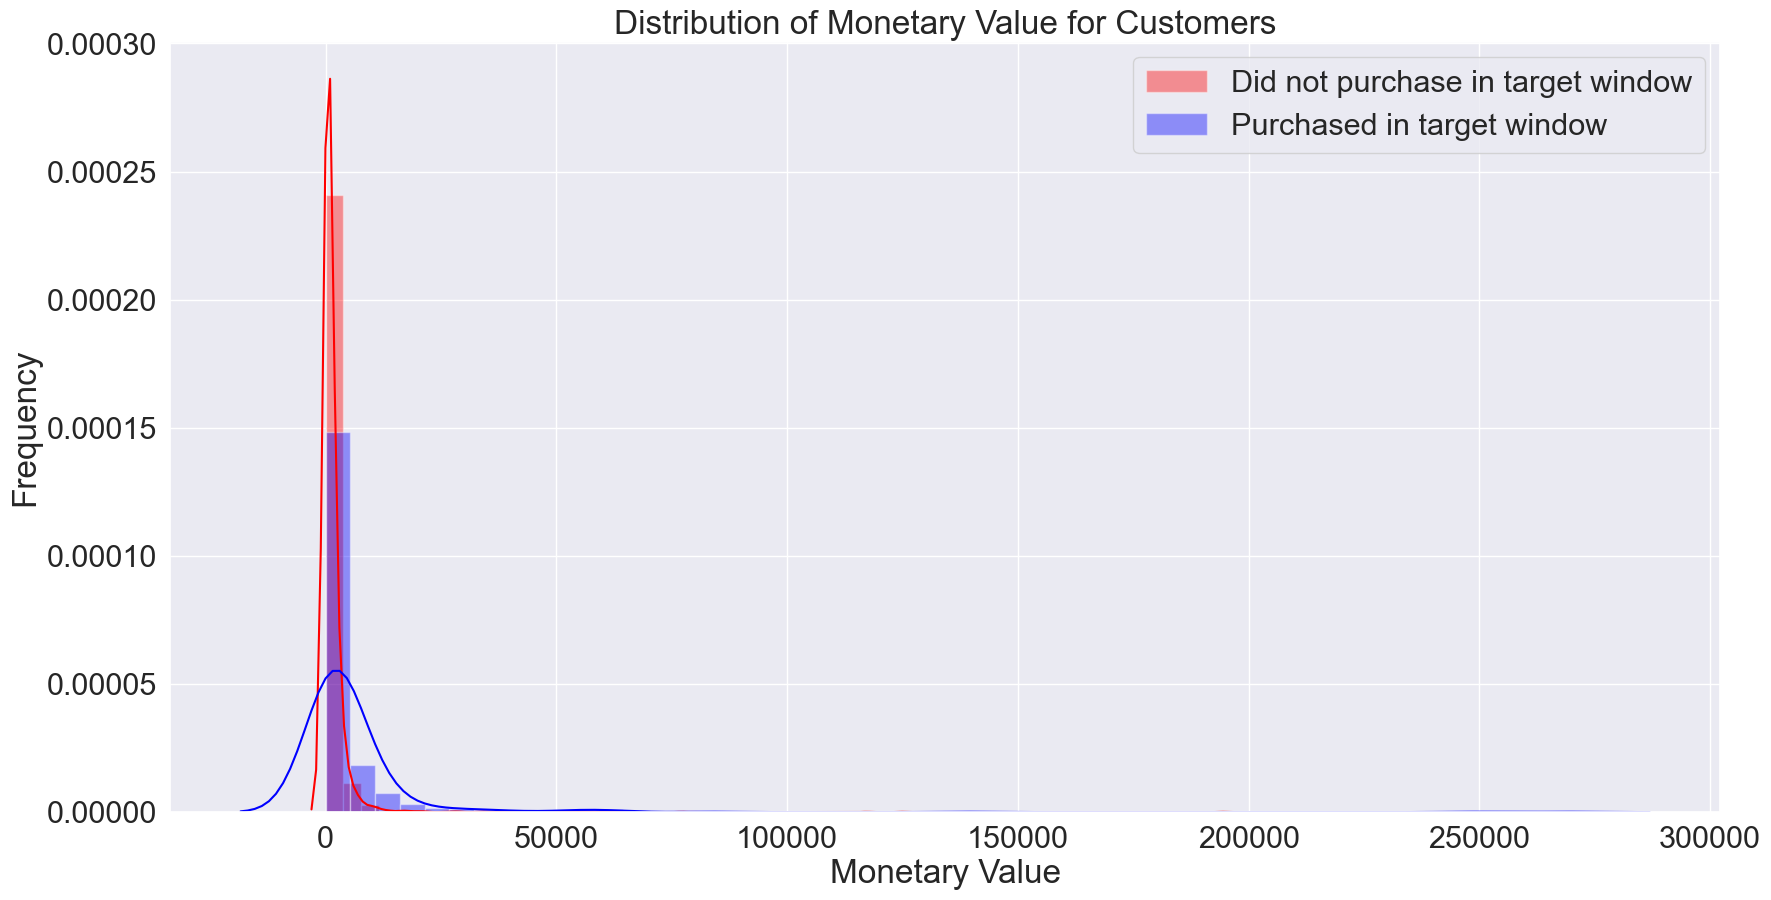

In [38]:
plt.figure(figsize = (20, 10))

sns.distplot(features[features['Purchase']==0]['Monetary Value'], color = 'red', label='Did not purchase in target window')
sns.distplot(features[features['Purchase']==1]['Monetary Value'], color = 'blue', label='Purchased in target window')
plt.ylabel('Frequency')
plt.xlabel('Monetary Value')
plt.title('Distribution of Monetary Value for Customers')
plt.legend()
plt.show()

This plot shows that customers who made a purchase in the target window have a higher monetary value than customers who didn't make a purchase. 

D:\NEXUS\SOFTWARE\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\NEXUS\SOFTWARE\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


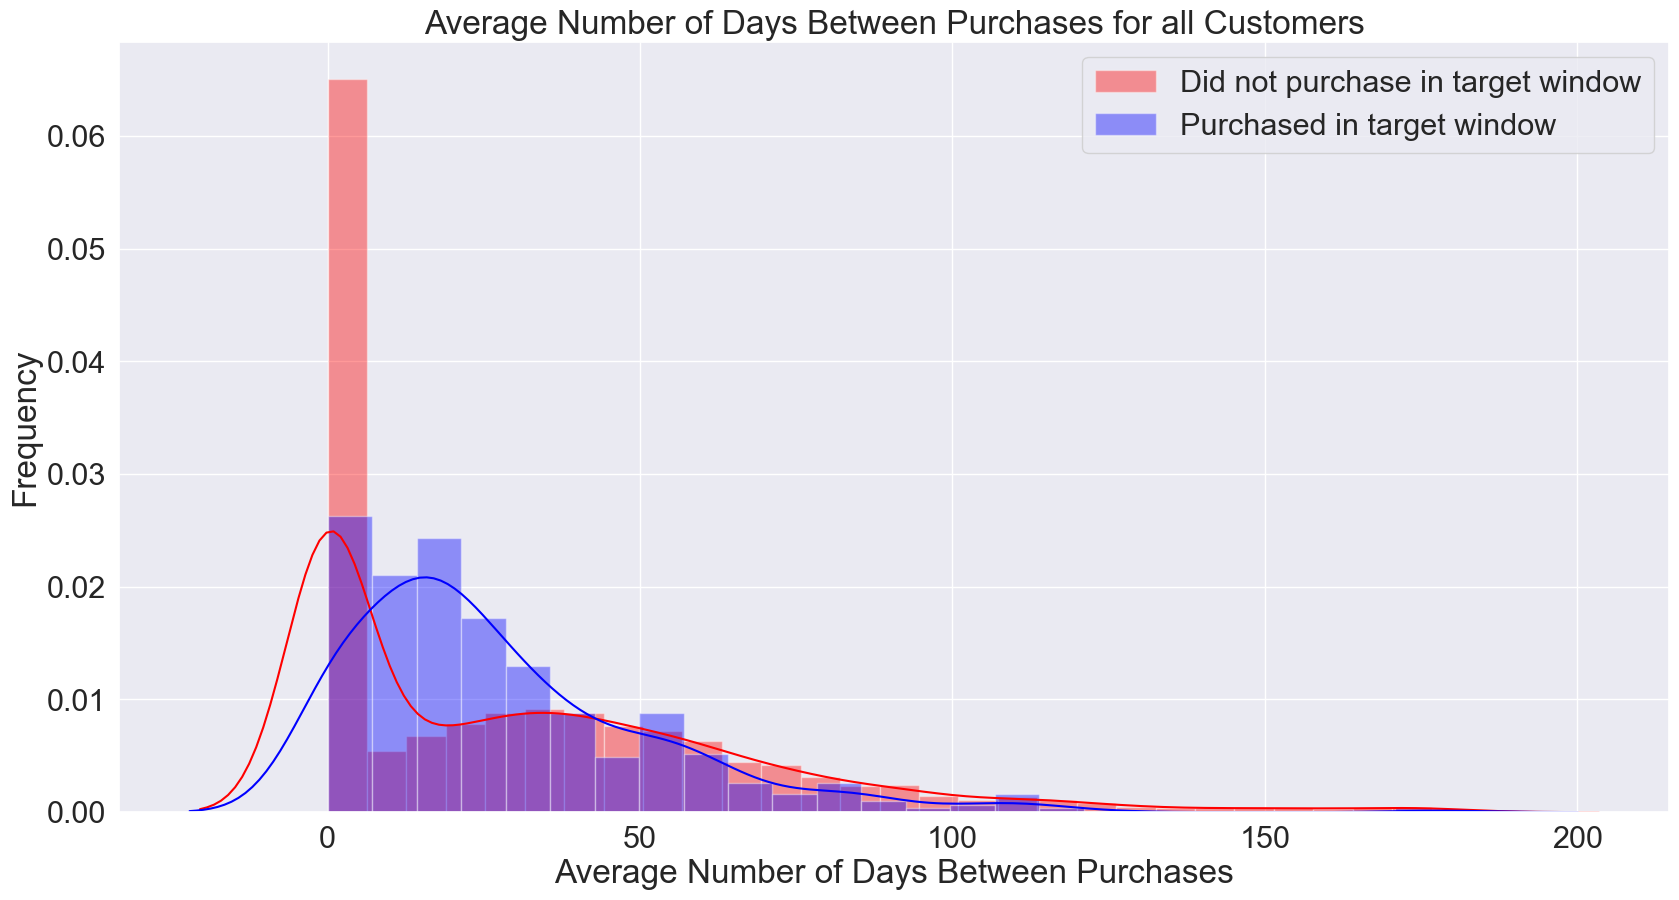

In [39]:
plt.figure(figsize = (20, 10))

sns.distplot(features[features['Purchase']==0]['Avg Time Between Purchases'], 
             color = 'red', label='Did not purchase in target window')
sns.distplot(features[features['Purchase']==1]['Avg Time Between Purchases'], 
             color = 'blue', label='Purchased in target window')
plt.ylabel('Frequency')
plt.xlabel('Average Number of Days Between Purchases')
plt.title('Average Number of Days Between Purchases for all Customers')
plt.legend()
plt.show()

Customers who purchased in the target window have a lower average number of days between purchases than customers who didn't make a purchase in the target window. 

# Machine Learning Model Development and Evaluation

Let's develop machine learning classification models using logistic regression, XGBoost, random forest, AdaBoost, and Gaussian Naive Bayes. Logistic regression serves as a baseline model for comparison. Models are evaluated using cross-validation. 75% of the training data is set aside to train the model and 25% is allocated to the test set. We will handle imbalanced data by balancing the ratio of the negative class to the positive class.    

In [40]:
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from scipy.stats import uniform
from scipy.stats import randint
import matplotlib.pyplot as plt

# Split into training and testing sets 
X = features.drop('Purchase', axis=1)
y = features['Purchase']
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size = 0.25, random_state=99)

In [45]:
# Logistic Regression - Baseline Model
logreg = LogisticRegression(random_state=0, class_weight='balanced')
logreg.fit(X_train,y_train)
logreg_pred = logreg.predict(X_test)

print("Logistic Regression - Testing Accuracy:", (round(accuracy_score(y_test, logreg_pred.round(0)), 2)))
print('\n')
print(confusion_matrix(y_test, logreg_pred))
print('\n')
print(classification_report(y_test, logreg_pred))
print('\n')
print("AUC Score:", roc_auc_score(y_test, logreg_pred))

Logistic Regression - Testing Accuracy: 0.71


[[692 277]
 [ 33  75]]


              precision    recall  f1-score   support

           0       0.95      0.71      0.82       969
           1       0.21      0.69      0.33       108

    accuracy                           0.71      1077
   macro avg       0.58      0.70      0.57      1077
weighted avg       0.88      0.71      0.77      1077



AUC Score: 0.7042913656690747


Our baseline model, logistic regression, has decent accuracy. AUC scores range from 0.5 (no better accuracy than chance) to 1.0 (perfect classifier).Let's see if our other models can do better. 

In [46]:
# XGBoost
weights = (y==0).sum()/(1.0 *  (y==1).sum())
xgb = XGBClassifier(silent=True,
                      random_state=1, 
                      scale_pos_weight=weights,
                      learning_rate=0.03,  
                      colsample_bytree = 0.8,
                      subsample = 0.7,
                      objective='binary:logistic', 
                      n_estimators=100, 
                      reg_alpha = 0.25,
                      min_child_weight = 2,
                      max_depth=5,
                      n_jobs = -1,
                      gamma=1)

xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

print("XGBoost - Testing Accuracy:", (round(accuracy_score(y_test, xgb_pred.round(0)), 2)))
print('\n')
print(confusion_matrix(y_test, xgb_pred))
print('\n')
print(classification_report(y_test, xgb_pred))
print('\n')
print("AUC Score:", roc_auc_score(y_test,xgb_pred))

[13:42:02] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

XGBoost - Testing Accuracy: 0.79


[[783 186]
 [ 41  67]]


              precision    recall  f1-score   support

           0       0.95      0.81      0.87       969
           1       0.26      0.62      0.37       108

    accuracy                           0.79      1077
   macro avg       0.61      0.71      0.62      1077
weighted avg       0.88      0.79      0.82      1077



AUC Score: 0.7142099529870427


After manually tuning the hyperparameters of our XGBoost model, we get an AUC of 0.73. XGBoost has higher model accuracy than our baseline logistic regression model. Let's see if we can increase our accuracy by tuning hyperparameters using *RandomSearchCV*. 

<AxesSubplot:>

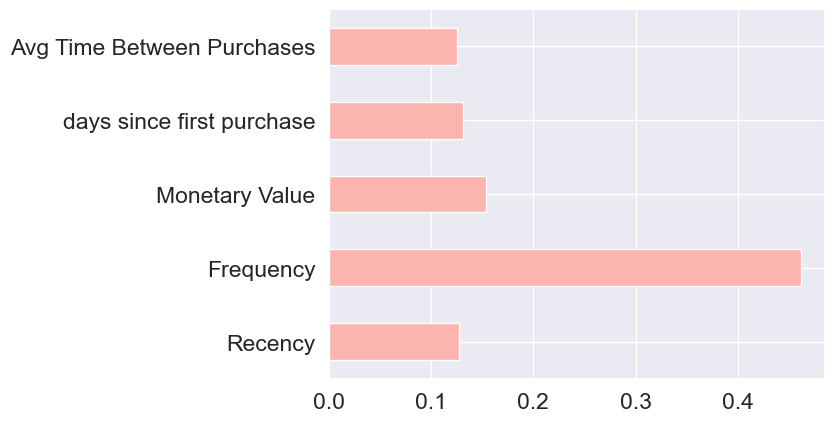

In [47]:
# XGBoost Feature Importance
(pd.Series(xgb.feature_importances_, index=X.columns)
   .plot(kind='barh', colormap = 'Pastel1'))  

In [48]:
# XGboost - Hyperparameter Tuning with Randomized Search CV 
weights = (y==0).sum()/(1.0 *  (y==1).sum())
xgb = XGBClassifier(random_state=1, scale_pos_weight = weights, n_jobs = -1, objective = 'binary:logistic')
xgb_params = {'n_estimators': randint(100, 300),
              'learning_rate': uniform(0.01, 0.05),
              'subsample': uniform(0.01, 0.5),
              'max_depth': [4, 5, 6, 7, 8],
              'colsample_bytree': uniform(0.01, 0.5),
              'min_child_weight': [1, 2, 3],
              'gamma': [0.3, 0.5, 0.7, 1]
             }

xgb_rs = RandomizedSearchCV(xgb,xgb_params,cv=10,n_jobs=-1, n_iter = 300, scoring = 'f1', error_score = 0, verbose = 3)
xgb_rs.fit(X_train, y_train)
print("XGB Best Parameters:", xgb_rs.best_params_)
print("XGB Best Score:", xgb_rs.best_score_)


Fitting 10 folds for each of 300 candidates, totalling 3000 fits
XGB Best Parameters: {'colsample_bytree': 0.3910330687019921, 'gamma': 1, 'learning_rate': 0.02840612147930116, 'max_depth': 7, 'min_child_weight': 2, 'n_estimators': 120, 'subsample': 0.09040295046332301}
XGB Best Score: 0.38826936885744423


In [49]:
xgb_pred = xgb_rs.predict(X_test)
print("XGBoost - Testing Accuracy:", (round(accuracy_score(y_test, xgb_pred.round(0)), 2)))
print('\n')
print(confusion_matrix(y_test, xgb_pred))
print('\n')
print(classification_report(y_test, xgb_pred))
print('\n')
print("AUC Score:", roc_auc_score(y_test,xgb_pred))

XGBoost - Testing Accuracy: 0.85


[[862 107]
 [ 52  56]]


              precision    recall  f1-score   support

           0       0.94      0.89      0.92       969
           1       0.34      0.52      0.41       108

    accuracy                           0.85      1077
   macro avg       0.64      0.70      0.66      1077
weighted avg       0.88      0.85      0.87      1077



AUC Score: 0.7040477009517258


Using the optimal hyperparameters from *RandomSearchCV* does not improve our AUC. Thus, we'll stick with our manually tuned XGBoost model.

In [41]:
# Random Forest 
rfc = RandomForestClassifier(random_state=1,
                             class_weight='balanced',
                             n_jobs = -1,
                             n_estimators=344,
                             max_depth=5,
                             min_samples_split=2,
                             min_samples_leaf=3,
                             max_features='auto',
                             criterion='gini'
                             )

rfc.fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)
                
print("Random Forest - Testing Accuracy:", (round(accuracy_score(y_test, rfc_pred.round(0)), 2)))
print('\n')
print(confusion_matrix(y_test, rfc_pred))
print('\n')
print(classification_report(y_test, rfc_pred))
print('\n')
print("AUC Score:", roc_auc_score(y_test,rfc_pred))

D:\NEXUS\SOFTWARE\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Random Forest - Testing Accuracy: 0.81


[[804 165]
 [ 38  70]]


              precision    recall  f1-score   support

           0       0.95      0.83      0.89       969
           1       0.30      0.65      0.41       108

    accuracy                           0.81      1077
   macro avg       0.63      0.74      0.65      1077
weighted avg       0.89      0.81      0.84      1077



AUC Score: 0.7389347551886252


Our random forest model slightly outperforms our XGBoost model. 

<AxesSubplot:>

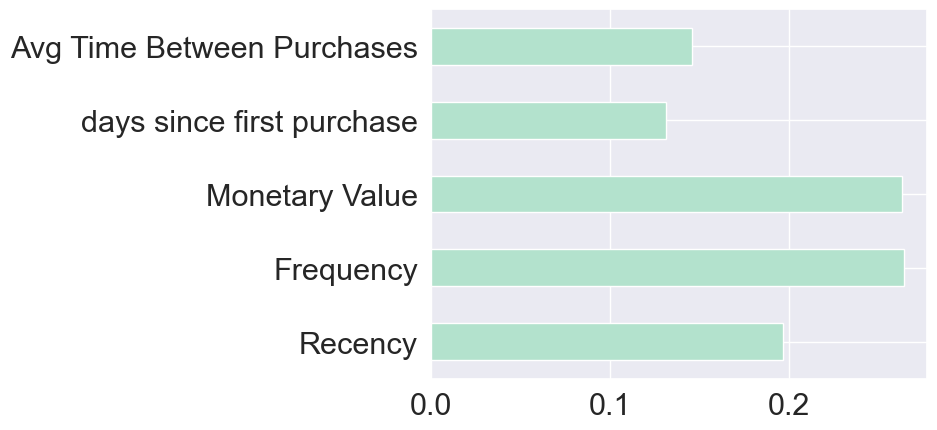

In [42]:
# Random Forest Feature Importance
(pd.Series(rfc.feature_importances_, index=X.columns)
   .plot(kind='barh', colormap = 'Pastel2'))

Since AdaBoost doesn't have a parameter that can balance the ratio of the negative class to the positive class, we will have to use a method known as undersampling to deal with the imbalanced data. 

<AxesSubplot:>

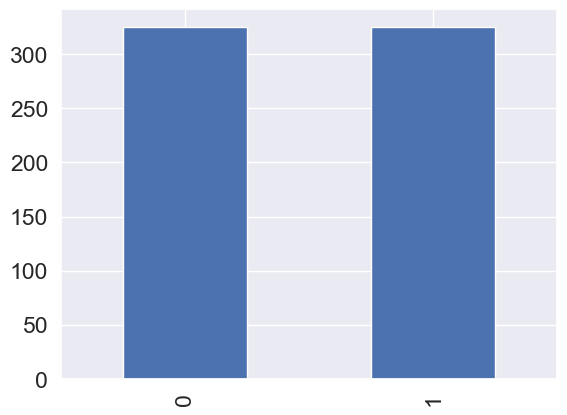

In [57]:
# RandomUnderSampler - Undersampling 
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state = 1)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
pd.Series(y_train_rus).value_counts().plot(kind='bar')

In [58]:
# Gaussian Naive Bayes
gnb = GaussianNB()
gnb.fit(X_train_rus,y_train_rus)
gnb_pred = gnb.predict(X_test)

print("Gaussian Naive Bayes - Testing Accuracy:", (round(accuracy_score(y_test, logreg_pred.round(0)), 2)))
print('\n')
print(confusion_matrix(y_test, logreg_pred))
print('\n')
print(classification_report(y_test, logreg_pred))
print('\n')
print("AUC Score:", roc_auc_score(y_test, logreg_pred))

Gaussian Naive Bayes - Testing Accuracy: 0.71


[[692 277]
 [ 33  75]]


              precision    recall  f1-score   support

           0       0.95      0.71      0.82       969
           1       0.21      0.69      0.33       108

    accuracy                           0.71      1077
   macro avg       0.58      0.70      0.57      1077
weighted avg       0.88      0.71      0.77      1077



AUC Score: 0.7042913656690747


Based on the AUC score, random forest is the most accurate model. 

# Propensity Scores

For the final step, let's use our best performing model (random forest) to output propensity scores for our customers. This will help us identify customers who have the highest probability of making a purchase in the next seven days. 

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=99)
X_train_data = X_train
X_test_data = X_test

rfc = RandomForestClassifier(random_state=1,
                             class_weight='balanced',
                             n_jobs = -1,
                             n_estimators=344,
                             max_depth=5,
                             min_samples_split=2,
                             min_samples_leaf=3,
                             max_features='auto',
                             criterion='gini'
                             )

rfc.fit(X_train_data, y_train)
rfc_pred = rfc.predict_proba(X_test_data)
df_propensity1 = pd.DataFrame(data=X_test)
df_propensity1['Purchase Probability'] = rfc_pred[:,1]

D:\NEXUS\SOFTWARE\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


In [44]:
rfc_pred_train = rfc.predict_proba(X_train_data)
df_propensity2 = pd.DataFrame(data=X_train)
df_propensity2['Purchase Probability'] = rfc_pred_train[:,1]

In [45]:
df_propensity = pd.concat([df_propensity1,df_propensity2],axis='rows')
df_propensity.shape

(4307, 6)

The users below have the highest probability of making a purchase.

In [46]:
df_propensity.sort_values(by=['Purchase Probability'], ascending=False).head()

,Recency,Frequency,Monetary Value,days since first purchase,Avg Time Between Purchases,Purchase Probability
CustomerID,,,,,,
15498.0,10,26,12451.46,359,13.423077,0.942407
16525.0,9,25,12705.73,359,14.000000,0.941355
13113.0,7,23,11906.76,359,15.304348,0.940367
13319.0,10,25,10536.45,358,13.920000,0.938644
17428.0,15,27,16841.25,361,12.814815,0.936842


The users below have the lowest probability of making a purchase.

In [47]:
df_propensity.sort_values(by=['Purchase Probability'], ascending=True).head()

,Recency,Frequency,Monetary Value,days since first purchase,Avg Time Between Purchases,Purchase Probability
CustomerID,,,,,,
12346.0,318,1,77183.60,318,0.0,0.069421
14439.0,312,1,2661.24,312,0.0,0.072213
12764.0,309,1,1693.88,309,0.0,0.075053
14935.0,290,1,1784.71,290,0.0,0.076768
16387.0,315,1,94.36,315,0.0,0.078424


In [48]:
propensity_90 = df_propensity[df_propensity['Purchase Probability'] >= 0.9]
propensity_80 = df_propensity[(df_propensity['Purchase Probability'] >= 0.8) & (df_propensity['Purchase Probability'] < 0.9) ]
propensity_70 = df_propensity[(df_propensity['Purchase Probability'] >= 0.7) & (df_propensity['Purchase Probability'] < 0.8) ]
propensity_60 = df_propensity[(df_propensity['Purchase Probability'] >= 0.6) & (df_propensity['Purchase Probability'] < 0.7) ]
propensity_50 = df_propensity[(df_propensity['Purchase Probability'] >= 0.5) & (df_propensity['Purchase Probability'] < 0.6) ]
propensity_40 = df_propensity[(df_propensity['Purchase Probability'] >= 0.4) & (df_propensity['Purchase Probability'] < 0.5) ]
propensity_30 = df_propensity[(df_propensity['Purchase Probability'] >= 0.3) & (df_propensity['Purchase Probability'] < 0.4) ]
propensity_20 = df_propensity[(df_propensity['Purchase Probability'] >= 0.2) & (df_propensity['Purchase Probability'] < 0.3) ]
propensity_10 = df_propensity[(df_propensity['Purchase Probability'] >= 0.1) & (df_propensity['Purchase Probability'] < 0.2) ]
propensity_0 = df_propensity[(df_propensity['Purchase Probability'] >= 0) & (df_propensity['Purchase Probability'] < 0.1) ]

In [49]:
propensity_90['Purchase Probability'] = "90 - 95%"
propensity_80['Purchase Probability'] = "80 - 89%"
propensity_70['Purchase Probability'] = "70 - 79%"
propensity_60['Purchase Probability'] = "60 - 69%"
propensity_50['Purchase Probability'] = "50 - 59%"
propensity_40['Purchase Probability'] = "40 - 49%"
propensity_30['Purchase Probability'] = "30 - 39%"
propensity_20['Purchase Probability'] = "20 - 29%"
propensity_10['Purchase Probability'] = "10 - 19%"
propensity_0['Purchase Probability']  = "7 - 9%"

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_2628\3869720498.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  propensity_90['Purchase Probability'] = "90 - 95%"
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_2628\3869720498.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  propensity_80['Purchase Probability'] = "80 - 89%"
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_2628\3869720498.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

In [50]:
propensity_dfs = [propensity_90, propensity_80, propensity_70, propensity_60, propensity_50, propensity_40, propensity_30, propensity_20, propensity_10, propensity_0]
purchase_prob = pd.concat(propensity_dfs)
purchase_prob['Purchase Probability'].value_counts()

20 - 29%    1018
30 - 39%     951
10 - 19%     830
40 - 49%     535
50 - 59%     367
60 - 69%     254
80 - 89%     115
70 - 79%      98
90 - 95%      76
7 - 9%        63
Name: Purchase Probability, dtype: int64

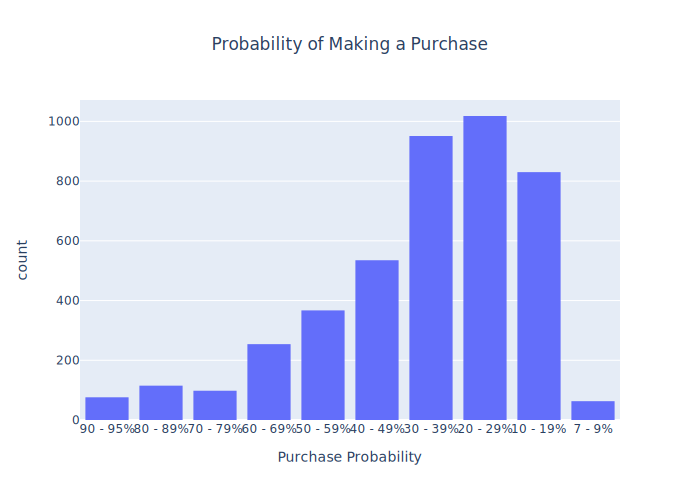

In [51]:
import plotly_express as px 
fig = px.histogram(data_frame=purchase_prob,
       x='Purchase Probability',
       template='plotly',
       title='Probability of Making a Purchase'     
      ).update(layout=dict(title=dict(x=0.5)))
fig.show("svg")

**Insights and Recommendations**: This chart helps us focus on decile groups that have the highest chance of making a purchase. The customers in the group on the far left are few in number but have the highest probability of making a purchase in the next seven days. In contrast, the group on the far right has the lowest probability of making a purchase in the target window. 

There are two ways we can apply marketing strategies to increase the likelihood that customers will make a purchase. If resources and funding are not an issue, we can give our marketing incentives to customers in the 70 – 79%, 60 - 69%, and 50 - 59% decile groups to increase the likelihood that they will make a purchase. Customers in the 90 – 95% and 80 - 89% decile groups already have a very high probability of making a purchase. Therefore, it may not be necessary to give them an incentive. The only time we should give them an incentive is when they don't make a purchase in the expected timeframe. If resources are limited, we should only give marketing incentives to customers in the decile groups between 70 - 95% if they don't make a purchase during the seven day window.
